In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import scipy.sparse.linalg

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from scipy.spatial import ConvexHull
from matplotlib.path import Path


We first load the 2000 data an find the min max values for every feature.

Features related to the predicted temperatures are removed. ('Temperature Annual Range', 'Min Temperature of Coldest Month', 'Annual Mean Temperature','Max Temperature of Warmest Month', 'Mean Diurnal Range', 'Temperature Seasonality'). Indeed, these features were not in min max range of 2000 dataset.

In [2]:
original_df = pd.read_csv('baseline_df.csv', index_col='pixel_id')
original_df_inputs = original_df.drop(['log_calories_per_ha', 'Temperature Annual Range', 'Min Temperature of Coldest Month', 'Annual Mean Temperature','Max Temperature of Warmest Month', 'Mean Diurnal Range', 'Temperature Seasonality'], axis=1).drop_duplicates()
min_max = original_df_inputs.apply(lambda x: pd.Series([x.min(), x.max()])).T.values.tolist()

min_max_dict = {}
for i, column in enumerate(original_df_inputs.columns):
    min_max_dict[column] = min_max[i]
min_max_dict

{'nutrient_availability_index': [1.0, 7.0],
 'oxygen_availability_index': [1.0, 7.0],
 'workability_index': [1.0, 7.0],
 'protected_areas_index': [0.0, 2.0],
 'nutrient_retention_index': [1.0, 7.0],
 'toxicity_index': [1.0, 7.0],
 'excess_salts_index': [1.0, 7.0],
 'rooting_conditions_index': [1.0, 7.0],
 'slope': [4.380776422507338e-05, 1.5707963267948966],
 'Isothermality': [14.046306194164176, 96.6964857388604],
 'Annual Precipitation': [0.0, 8122.0],
 'Precipitation of Wettest Month': [0.0, 2578.0],
 'Precipitation of Driest Month': [0.0, 501.0],
 'Precipitation Seasonality': [0.0, 217.40899059346063],
 'fertl_c3ann': [-9999.0, 297.25000000000006],
 'fertl_c3nfx': [-9999.0, 338.7929992675782],
 'fertl_c3per': [-9999.0, 487.14099121093767],
 'fertl_c4ann': [-9999.0, 604.7890014648439],
 'fertl_c4per': [-9999.0, -9999.0],
 'log_altitude': [0.0, 8.77539495854551],
 'log_GDP_pc': [-3.3885248304083886, 4.230240022141504]}

In [3]:
# returns true if all features are within minmax
# of 2000 data
def is_in_min_max(row, min_max):
    for column in original_df_inputs.columns:
        feature = row[column]
        if feature < min_max_dict[column][0] or feature >  min_max_dict[column][1]:
            return 0
    return 1

# returns proportion of data points within 2000 data min max
def get_proportion_in_min_max(min_max, prediction_df):
    inside = prediction_df.apply(lambda row: is_in_min_max(row, min_max), axis=1).sum()
    total_points = len(prediction_df)
    return inside, total_points, inside/total_points

prediction_df_cc_ssp1 = pd.read_csv('he_ssp1.csv', index_col='pixel_id')
print(len(prediction_df_cc_ssp1))
get_proportion_in_min_max(min_max, prediction_df_cc_ssp1)

/home/kyle/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1060997


(969108, 1060997, 0.9133937230736751)

We see that more than 91% of datapoints are within the cuboid minmax formed from the 2000 dataset used for training.

We will now look at which features are outside the cuboid.

In [10]:
# returns features that are not within minmax
# of 2000 data
def features_not_in_min_max(row, min_max):
    features=[]
    for column in original_df_inputs.columns:
        feature = row[column]
        if feature < min_max_dict[column][0] or feature >  min_max_dict[column][1]:
            features.append(column)
    return features
outside_features = prediction_df_cc_ssp1.apply(lambda row: features_not_in_min_max(row, min_max), axis=1)

In [12]:
outside_features = outside_features[outside_features.str.len()>0]
print('mean number of features not in min max',outside_features.apply(lambda val: len(val)).mean())
outside_features = outside_features.apply(pd.Series).unstack().reset_index().dropna()

mean 1.0006094309438562


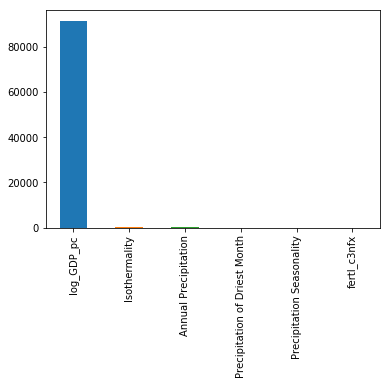

In [19]:
# plot count for features not in min max
outside_features[0].value_counts().plot.bar()

The log GDP is largely responsible for the 9% of values not in min max cuboid.